In [2]:
# CLIP and model loading
import open_clip

import open_clip

# PyTorch
import torch
from torch.utils.data import DataLoader

# Dataset
from torchvision.datasets import CIFAR10

# Machine Learning utilities
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression

# Visualization
import matplotlib.pyplot as plt

# Progress bar
from tqdm import tqdm

# File I/O
import os
import seaborn as sns
import random


c:\Users\Muhammad Ahmad\AppData\Local\Programs\Python\Python314\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import open_clip

model_name = "ViT-B-32"
pretrained_dataset = "openai"
# Select device
device = "cpu"
print("Using device:", device)

# Load model + preprocessing function
model, _, preprocess = open_clip.create_model_and_transforms(
    model_name,
    pretrained=pretrained_dataset,
    device=device
)

# Move model to correct device
model = model.to(device)

print("Model loaded successfully!")

Using device: cpu


c:\Users\Muhammad Ahmad\AppData\Local\Programs\Python\Python314\Lib\site-packages\open_clip\factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


Model loaded successfully!


In [4]:
# --------------------------------------------------------
# Step 6: Encode All CIFAR-10 Images (Fixed + Optimized)
# --------------------------------------------------------

from torch.utils.data import DataLoader, Subset
import numpy as np
import random
import torch

# --------------------------------------------------------
# 0. SET SEEDS FOR REPRODUCIBILITY  (Robustness Improvement)
# --------------------------------------------------------
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

# --------------------------------------------------------
# 1. Load CIFAR-10 test set WITHOUT transforms (for selection)
# --------------------------------------------------------
full_test_raw = CIFAR10(root="data", train=False, download=True)

# --------------------------------------------------------
# 2. Select 100 images per class (total 1000)
# --------------------------------------------------------
indices = []
class_counts = {c: 0 for c in range(10)}

for i, (_, label) in enumerate(full_test_raw):
    if class_counts[label] < 100:
        indices.append(i)
        class_counts[label] += 1
    if len(indices) == 1000:
        break

print("Number of selected images:", len(indices))  # Should print 1000

# --------------------------------------------------------
# 3. Reload dataset WITH preprocess transform
# --------------------------------------------------------
full_test = CIFAR10(root="data", train=False, download=True, transform=preprocess)

# Create the dataset subset of 1000 images
test_dataset = Subset(full_test, indices)

# --------------------------------------------------------
# 4. DataLoader for fast batch encoding (Robust + Fast)
# --------------------------------------------------------
loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

true_labels = []
image_features_list = []

print("Encoding CIFAR-10 gallery images (1000 images)...")

# --------------------------------------------------------
# 5. Encode images using CLIP in batches
# --------------------------------------------------------
with torch.no_grad():
    for batch_imgs, batch_labels in tqdm(loader):

        batch_imgs = batch_imgs.to(device)

        # CLIP Image Encoder
        feats = model.encode_image(batch_imgs)

        # IMPORTANT: Normalize embeddings (Robustness Improvement)
        feats = feats / feats.norm(dim=-1, keepdim=True)

        # Store results
        image_features_list.append(feats.cpu())
        true_labels.extend(batch_labels.numpy())

# --------------------------------------------------------
# 6. Combine features into final tensors
# --------------------------------------------------------
image_features = torch.cat(image_features_list, dim=0)
true_labels_np = np.array(true_labels)

print("Encoding complete!")
print("Image features shape:", image_features.shape)   # Expected: (1000, 512)
print("True labels shape:", true_labels_np.shape)       # Expected: (1000,)



Number of selected images: 1000
Encoding CIFAR-10 gallery images (1000 images)...


100%|██████████| 16/16 [00:51<00:00,  3.20s/it]

Encoding complete!
Image features shape: torch.Size([1000, 512])
True labels shape: (1000,)



===== SINGLE CANONICAL PROMPT RESULTS =====
Recall@1: 0.851
Recall@5: 0.996



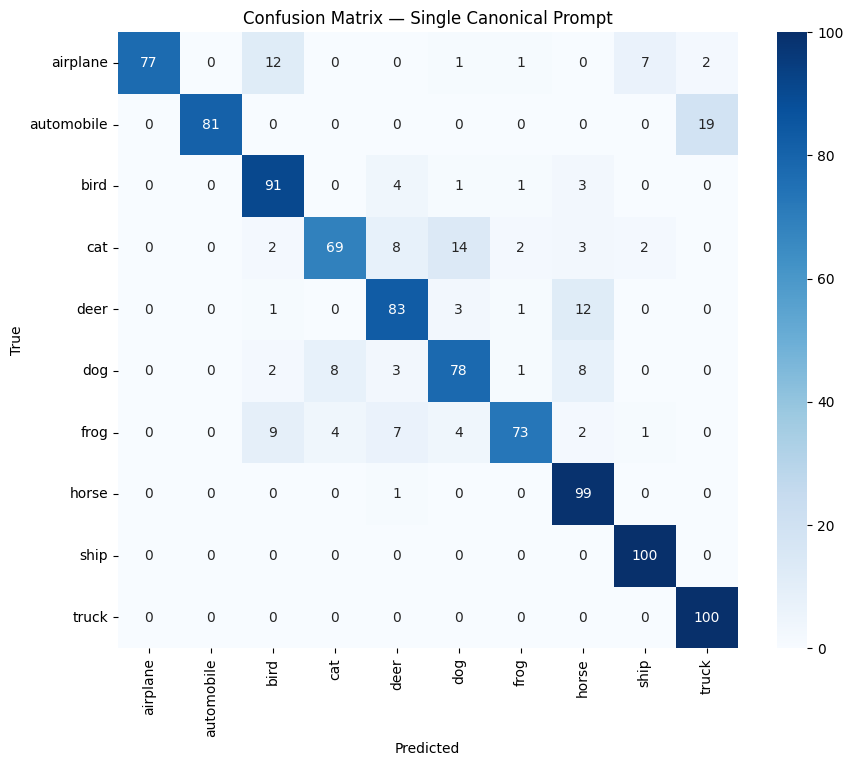


===== TOP-5 BEST RETRIEVALS (PER CLASS) =====


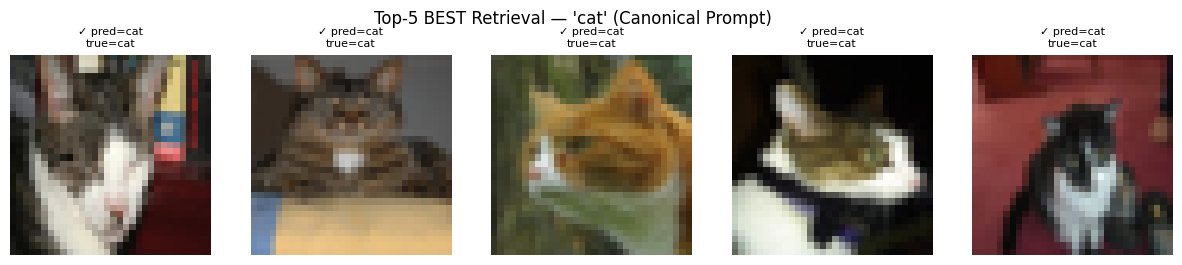

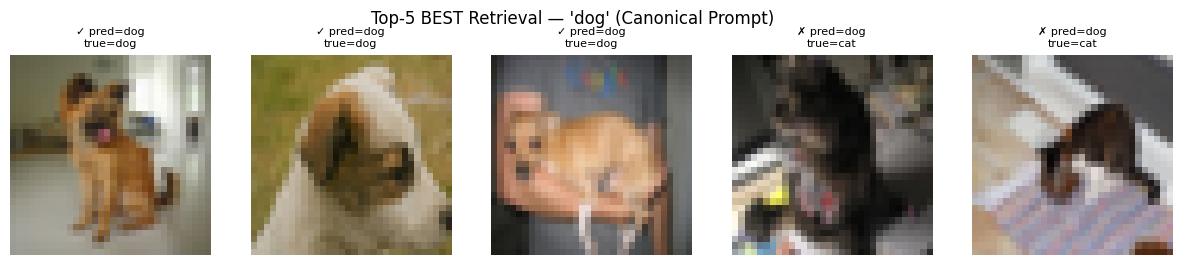

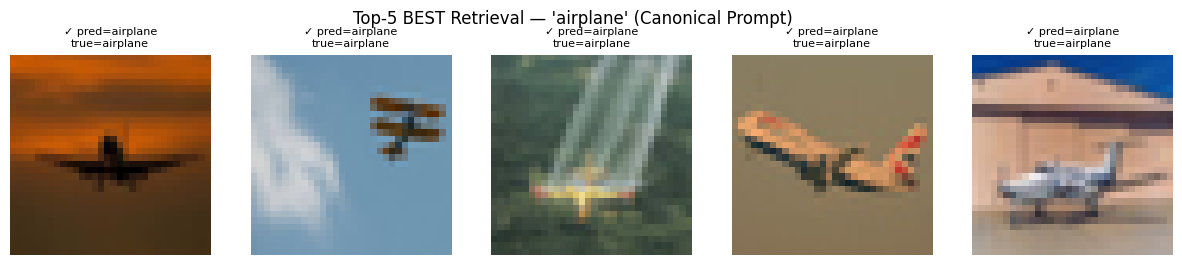

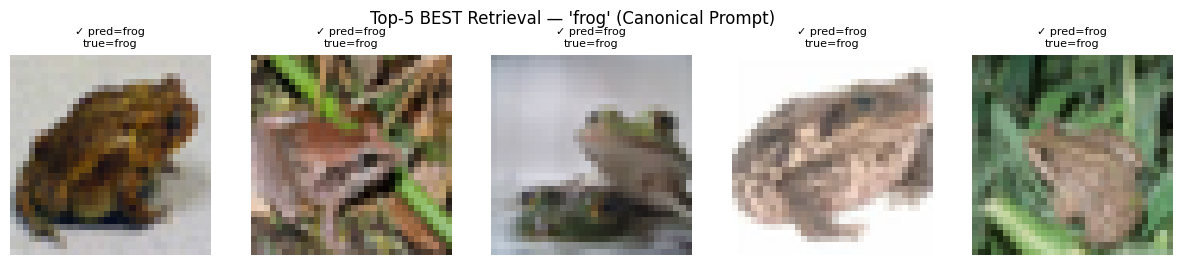


===== TOP-5 WORST RETRIEVALS (PER CLASS) =====


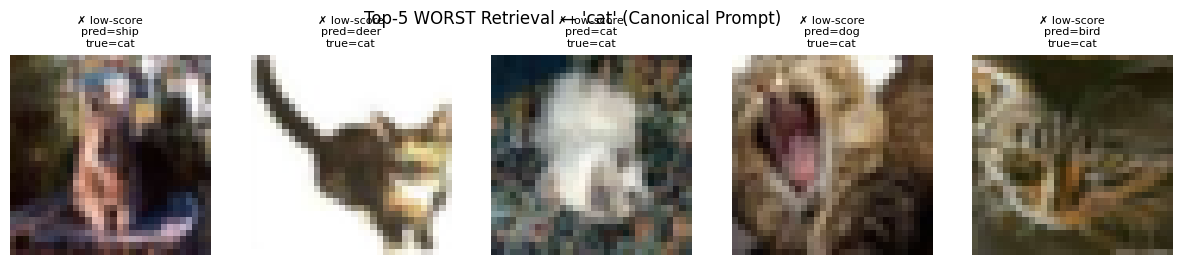

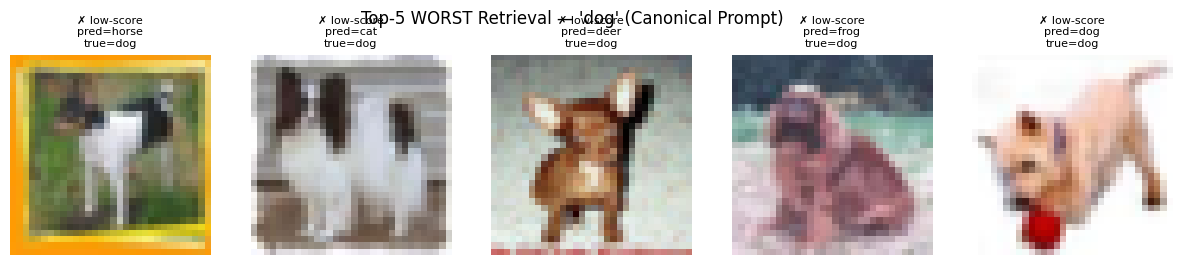

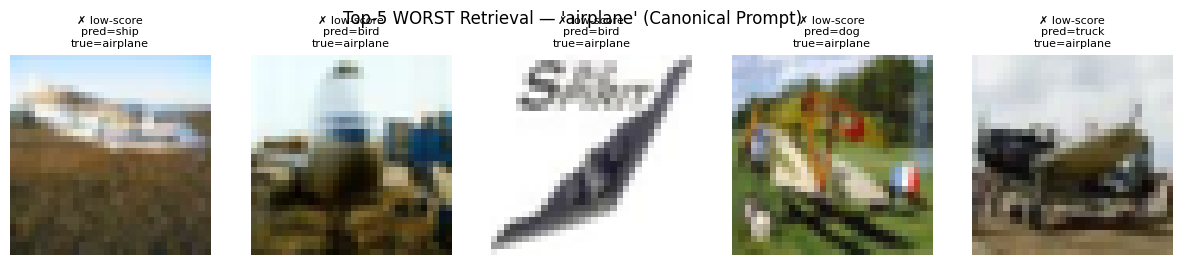

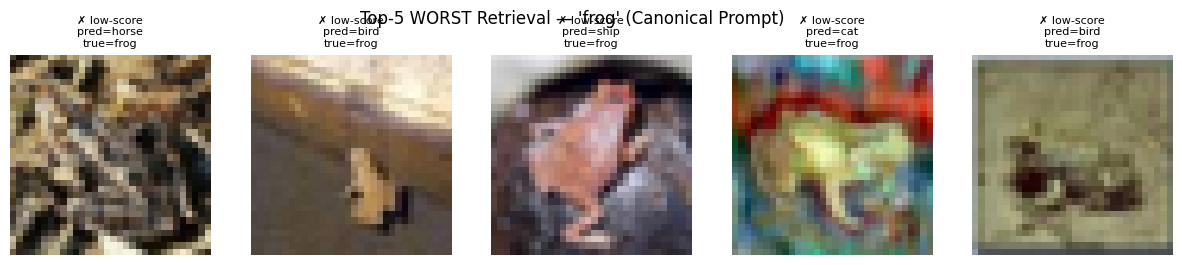

In [26]:
# ==========================================================
# SINGLE CANONICAL PROMPT ZERO-SHOT (BEST + WORST PER CLASS)
# ==========================================================

from open_clip import tokenize
import torch, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import confusion_matrix

device = "cpu"

# ----------------------------------------------------------
# 1. Load CIFAR-10 and Select 1000 Images (100 per class)
# ----------------------------------------------------------
full_test_raw = CIFAR10(root="data", train=False, download=True)
class_names = full_test_raw.classes

np.random.seed(0)
indices = []
class_count = {c: 0 for c in range(10)}

for idx, (_, lbl) in enumerate(full_test_raw):
    if class_count[lbl] < 100:
        indices.append(idx)
        class_count[lbl] += 1
    if len(indices) == 1000:
        break

full_test_pre = CIFAR10(root="data", train=False, download=True, transform=preprocess)
test_dataset = Subset(full_test_pre, indices)
loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# ----------------------------------------------------------
# 2. Encode Image Features
# ----------------------------------------------------------
image_features, true_labels = [], []

with torch.no_grad():
    for imgs, labels in loader:
        feats = model.encode_image(imgs.to(device))
        feats = feats / feats.norm(dim=-1, keepdim=True)
        image_features.append(feats.cpu())
        true_labels.extend(labels.numpy())

image_features = torch.cat(image_features, dim=0)
true_labels_np = np.array(true_labels)


# ----------------------------------------------------------
# 3. Encode Canonical Prompts
# ----------------------------------------------------------
canonical_prompts = [f"a photo of a {c}" for c in class_names]
tokens = tokenize(canonical_prompts).to(device)

with torch.no_grad():
    text_feats = model.encode_text(tokens)
    text_feats = text_feats / text_feats.norm(dim=-1, keepdim=True)


# ----------------------------------------------------------
# 4. Compute Similarity + Predictions
# ----------------------------------------------------------
sim = (image_features @ text_feats.T).numpy()
canonical_pred = np.argmax(sim, axis=1)


# ----------------------------------------------------------
# 5. Compute Metrics
# ----------------------------------------------------------
def recall_at_1(true, pred):
    return np.mean(true == pred)

def recall_at_5(true, sims):
    top5 = np.argsort(sims, axis=1)[:, -5:]
    return np.mean([true[i] in top5[i] for i in range(len(true))])

print("\n===== SINGLE CANONICAL PROMPT RESULTS =====")
print("Recall@1:", recall_at_1(true_labels_np, canonical_pred))
print("Recall@5:", recall_at_5(true_labels_np, sim))
print("============================================\n")


# ----------------------------------------------------------
# 6. Confusion Matrix
# ----------------------------------------------------------
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(true_labels_np, canonical_pred),
            annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix — Single Canonical Prompt")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# ==========================================================
# 7. BEST + WORST RETRIEVALS PER CLASS
# ==========================================================

# --- Helper function: show BEST ---
def show_top5_best_single(query_class, sim_matrix):
    cls_idx = class_names.index(query_class)
    cls_sim = sim_matrix[:, cls_idx]

    top5 = np.argsort(cls_sim)[-5:][::-1]

    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(top5):
        img, lbl = full_test_raw[indices[idx]]
        pred = canonical_pred[idx]
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis("off")
        mark = "✓" if pred == lbl else "✗"
        plt.title(f"{mark} pred={class_names[pred]}\ntrue={class_names[lbl]}", fontsize=8)

    plt.suptitle(f"Top-5 BEST Retrieval — '{query_class}' (Canonical Prompt)")
    plt.show()


# --- Helper function: show WORST (for that class) ---
def show_top5_worst_single(query_class, sim_matrix):
    cls_idx = class_names.index(query_class)

    # Filter images that actually belong to this class
    class_indices = np.where(true_labels_np == cls_idx)[0]
    cls_sim = sim_matrix[class_indices, cls_idx]

    # lowest similarity = worst retrieval
    worst5 = class_indices[np.argsort(cls_sim)[:5]]

    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(worst5):
        img, lbl = full_test_raw[indices[idx]]
        pred = canonical_pred[idx]
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(
            f"✗ low-score\npred={class_names[pred]}\ntrue={class_names[lbl]}",
            fontsize=8
        )

    plt.suptitle(f"Top-5 WORST Retrieval — '{query_class}' (Canonical Prompt)")
    plt.show()


# ==========================================================
# 8. Run for selected classes
# ==========================================================

selected_classes = ["cat", "dog", "airplane", "frog"]

print("\n===== TOP-5 BEST RETRIEVALS (PER CLASS) =====")
for cls in selected_classes:
    show_top5_best_single(cls, sim)

print("\n===== TOP-5 WORST RETRIEVALS (PER CLASS) =====")
for cls in selected_classes:
    show_top5_worst_single(cls, sim)



In [6]:
# ========================================================
# BASELINE ZERO-SHOT (Single Prompt)
# ========================================================

import numpy as np

# 1. Single canonical prompt for each class
canonical_prompts = [f"a photo of a {c}" for c in class_names]
tokens = tokenize(canonical_prompts).to(device)

with torch.no_grad():
    canonical_text_features = model.encode_text(tokens)
    canonical_text_features = canonical_text_features / canonical_text_features.norm(dim=-1, keepdim=True)

# 2. Zero-shot prediction
with torch.no_grad():
    similarity = 100.0 * (image_features.to(device) @ canonical_text_features.T)
    probs = similarity.softmax(dim=-1)
    baseline_pred = probs.argmax(dim=-1).cpu().numpy()

baseline_accuracy = accuracy_score(true_labels_np, baseline_pred)
print("Baseline Accuracy:", baseline_accuracy)
print("baseline_pred shape:", baseline_pred.shape)

# ========================================================
# BASELINE RETRIEVAL METRICS (Recall@1 and Recall@5)
# ========================================================

def recall_at_1(true_labels, pred_labels):
    return np.mean(true_labels == pred_labels)

def recall_at_5(true_labels, sim_matrix):
    top5 = np.argsort(sim_matrix, axis=1)[:, -5:]
    hits = [true_labels[i] in top5[i] for i in range(len(true_labels))]
    return np.mean(hits)

baseline_sim_np = similarity.cpu().numpy()

baseline_r1 = recall_at_1(true_labels_np, baseline_pred)
baseline_r5 = recall_at_5(true_labels_np, baseline_sim_np)

print("\n===== BASELINE RETRIEVAL METRICS =====")
print(f"Recall@1: {baseline_r1:.3f}")
print(f"Recall@5: {baseline_r5:.3f}")


Baseline Accuracy: 0.851
baseline_pred shape: (1000,)

===== BASELINE RETRIEVAL METRICS =====
Recall@1: 0.851
Recall@5: 0.996



========== UNIVERSAL TEMPLATE ZERO-SHOT ==========

Using 6 universal templates for 10 classes.

Universal prototype shape: torch.Size([10, 512])

===== UNIVERSAL TEMPLATE RESULTS =====
Recall@1: 0.8550
Recall@5: 0.9920



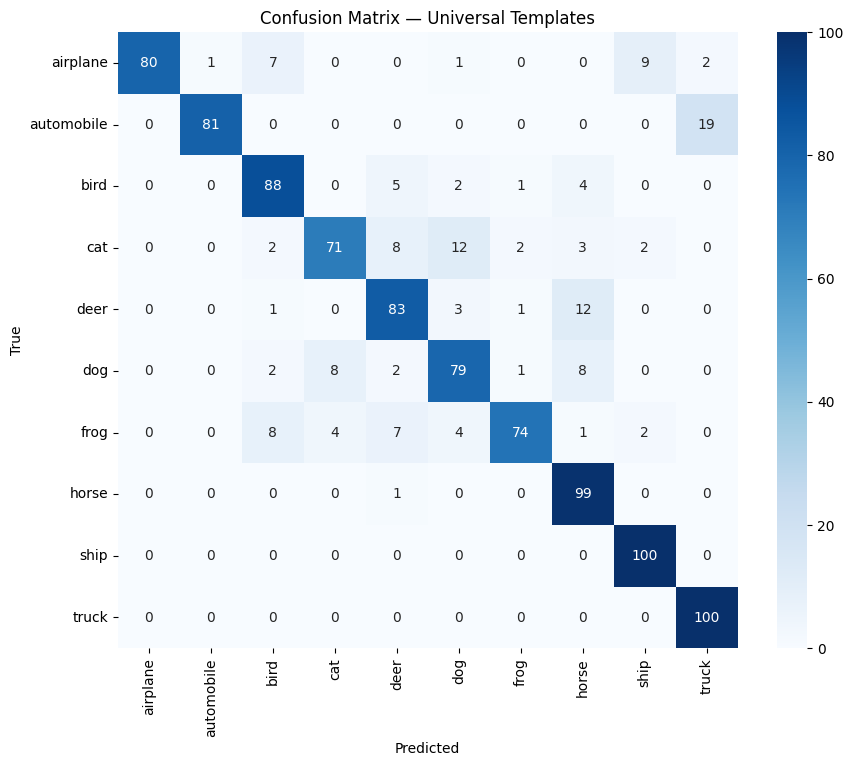


===== TOP-5 BEST RETRIEVALS (PER CLASS) =====


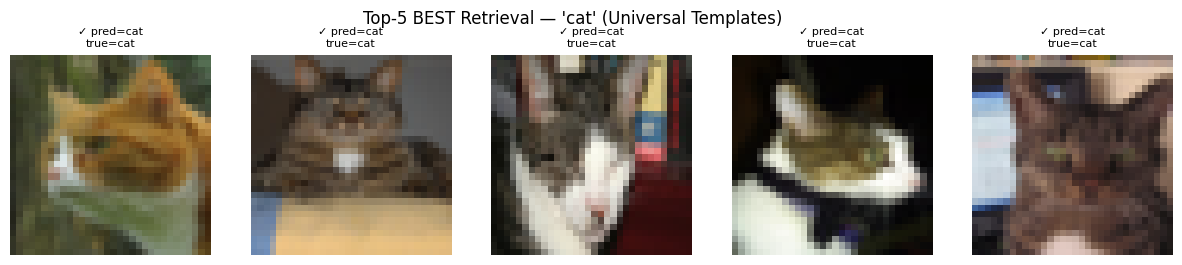

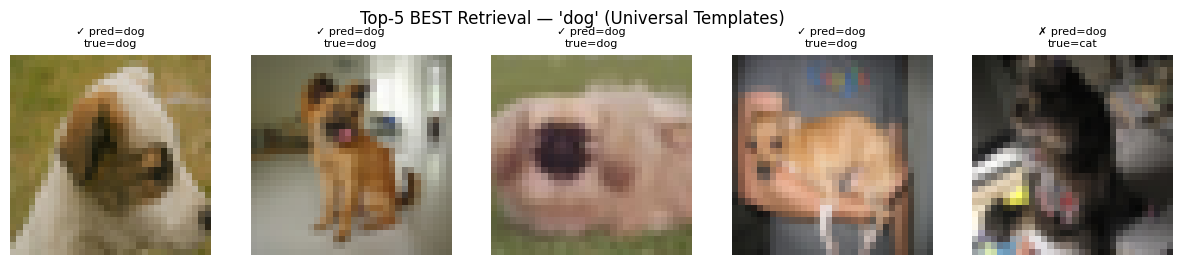

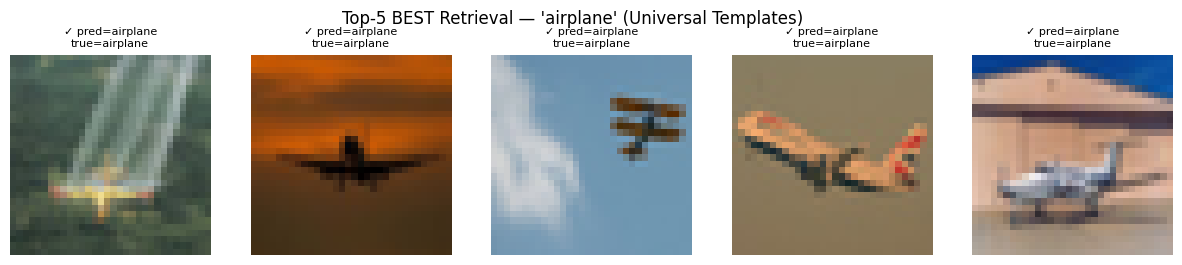

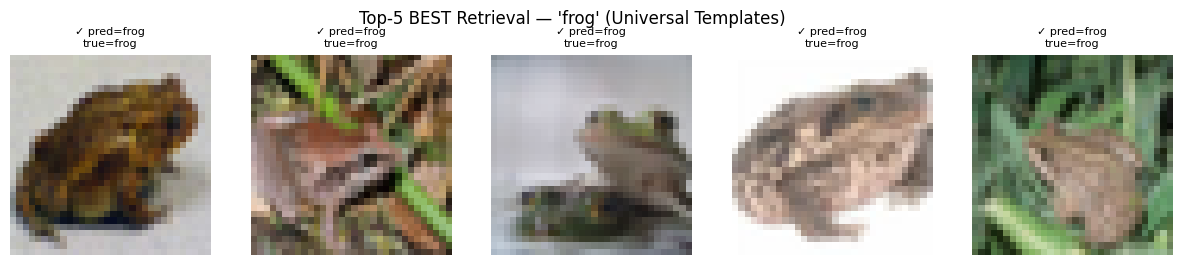


===== TOP-5 WORST RETRIEVALS (PER CLASS) =====


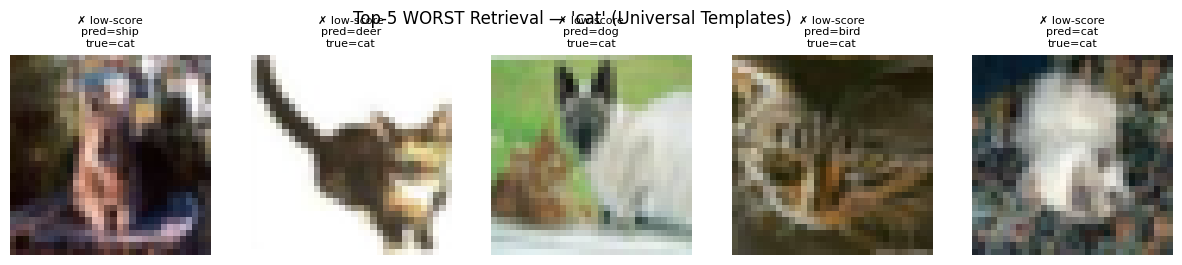

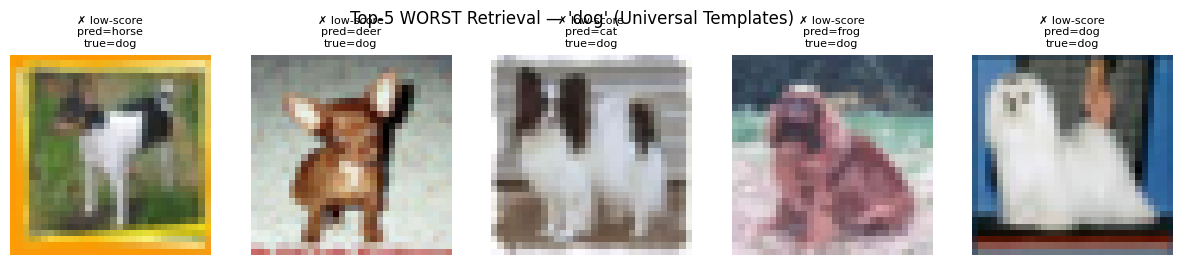

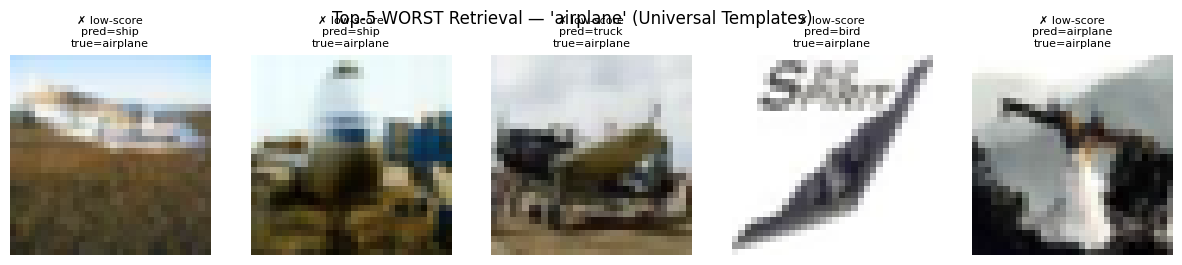

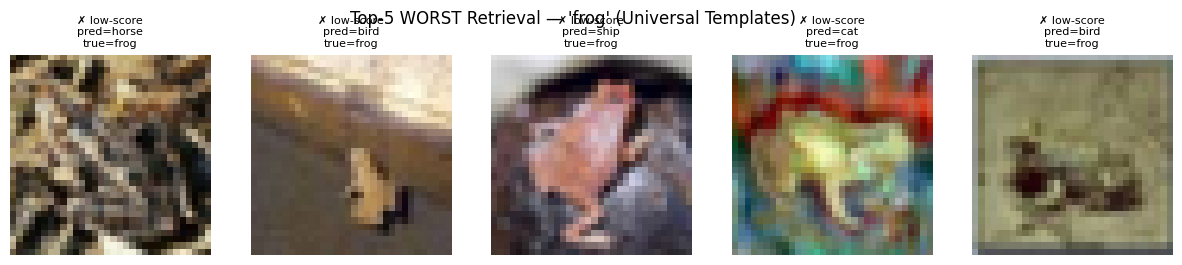

In [24]:
# ==========================================================
# UNIVERSAL TEMPLATE ZERO-SHOT PIPELINE (WITH BEST + WORST)
# ==========================================================

i# ==========================================================
# UNIVERSAL TEMPLATE ZERO-SHOT PIPELINE (WITH BEST + WORST + PREDICTIONS)
# ==========================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from open_clip import tokenize
from sklearn.metrics import confusion_matrix

print("\n========== UNIVERSAL TEMPLATE ZERO-SHOT ==========\n")


# ----------------------------------------------------------
# 1. UNIVERSAL PROMPTS
# ----------------------------------------------------------
universal_templates = [
    "a photo of a {}",
    "an image of a {}",
    "a close-up photo of a {}",
    "a low-resolution photo of a {}",
    "a professional image of a {}",
    "a natural scene containing a {}"
]

T = len(universal_templates)
C = len(class_names)

print(f"Using {T} universal templates for {C} classes.\n")


# ----------------------------------------------------------
# 2. Prompt expansion → tokenize → embed
# ----------------------------------------------------------
all_prompts = []
for cls in class_names:
    for temp in universal_templates:
        all_prompts.append(temp.format(cls))

tokens = tokenize(all_prompts).to(device)

with torch.no_grad():
    uf = model.encode_text(tokens)
    uf = uf / uf.norm(dim=-1, keepdim=True)

uf = uf.reshape(C, T, -1)
universal_prototypes = uf.mean(dim=1)  # (10, 512)

print("Universal prototype shape:", universal_prototypes.shape)


# ----------------------------------------------------------
# 3. Similarity scores
# ----------------------------------------------------------
with torch.no_grad():
    sim_uni = 100.0 * (image_features.to(device) @ universal_prototypes.T)

uni_sim = sim_uni.cpu().numpy()
uni_pred = uni_sim.argmax(axis=1)


# ----------------------------------------------------------
# 4. Metrics
# ----------------------------------------------------------
def recall_at_1(true, pred):
    return np.mean(true == pred)

def recall_at_5(true, sim_matrix):
    top5 = np.argsort(sim_matrix, axis=1)[:, -5:]
    return np.mean([true[i] in top5[i] for i in range(len(true))])

uni_r1 = recall_at_1(true_labels_np, uni_pred)
uni_r5 = recall_at_5(true_labels_np, uni_sim)

print("\n===== UNIVERSAL TEMPLATE RESULTS =====")
print(f"Recall@1: {uni_r1:.4f}")
print(f"Recall@5: {uni_r5:.4f}")
print("======================================\n")


# ----------------------------------------------------------
# 5. Confusion Matrix
# ----------------------------------------------------------
cm = confusion_matrix(true_labels_np, uni_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix — Universal Templates")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# ==========================================================
# 6. VISUALISATION FUNCTIONS — UPDATED WITH PREDICTED LABELS
# ==========================================================

# ----------------------------------------------------------
# 6A. BEST retrieval for a class
# ----------------------------------------------------------
def show_top5_best_universal(query_class, sim_matrix):
    cls_idx = class_names.index(query_class)
    cls_sim = sim_matrix[:, cls_idx]
    top5 = np.argsort(cls_sim)[-5:][::-1]

    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(top5):

        img, lbl = full_test_raw[indices[idx]]
        true_name = class_names[lbl]
        pred_name = class_names[uni_pred[idx]]

        correct = "✓" if pred_name == true_name else "✗"

        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{correct} pred={pred_name}\ntrue={true_name}", fontsize=8)

    plt.suptitle(f"Top-5 BEST Retrieval — '{query_class}' (Universal Templates)")
    plt.show()


# ----------------------------------------------------------
# 6B. WORST retrieval for a class
# ----------------------------------------------------------
def show_top5_worst_for_class_universal(query_class, sim_matrix):
    cls_idx = class_names.index(query_class)

    # similarities for THIS class only
    cls_sim = sim_matrix[:, cls_idx]

    # find ground-truth images for this class
    class_indices = np.where(true_labels_np == cls_idx)[0]

    # select lowest similarity (worst) cases
    worst5 = class_indices[np.argsort(cls_sim[class_indices])[:5]]

    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(worst5):

        img, lbl = full_test_raw[indices[idx]]
        true_name = class_names[lbl]
        pred_name = class_names[uni_pred[idx]]

        wrong_flag = "✗ low-score"

        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{wrong_flag}\npred={pred_name}\ntrue={true_name}", fontsize=8)

    plt.suptitle(f"Top-5 WORST Retrieval — '{query_class}' (Universal Templates)")
    plt.show()


# ==========================================================
# 7. DISPLAY BEST + WORST FOR SELECTED CLASSES
# ==========================================================
selected_classes = ["cat", "dog", "airplane", "frog"]

print("\n===== TOP-5 BEST RETRIEVALS (PER CLASS) =====")
for cls in selected_classes:
    show_top5_best_universal(cls, uni_sim)

print("\n===== TOP-5 WORST RETRIEVALS (PER CLASS) =====")
for cls in selected_classes:
    show_top5_worst_for_class_universal(cls, uni_sim)



========== CLASS-SPECIFIC TEMPLATE ZERO-SHOT ==========

Class-specific templates loaded!


===== CLASS-SPECIFIC TEMPLATE RESULTS =====
Recall@1: 0.8630
Recall@5: 0.9970



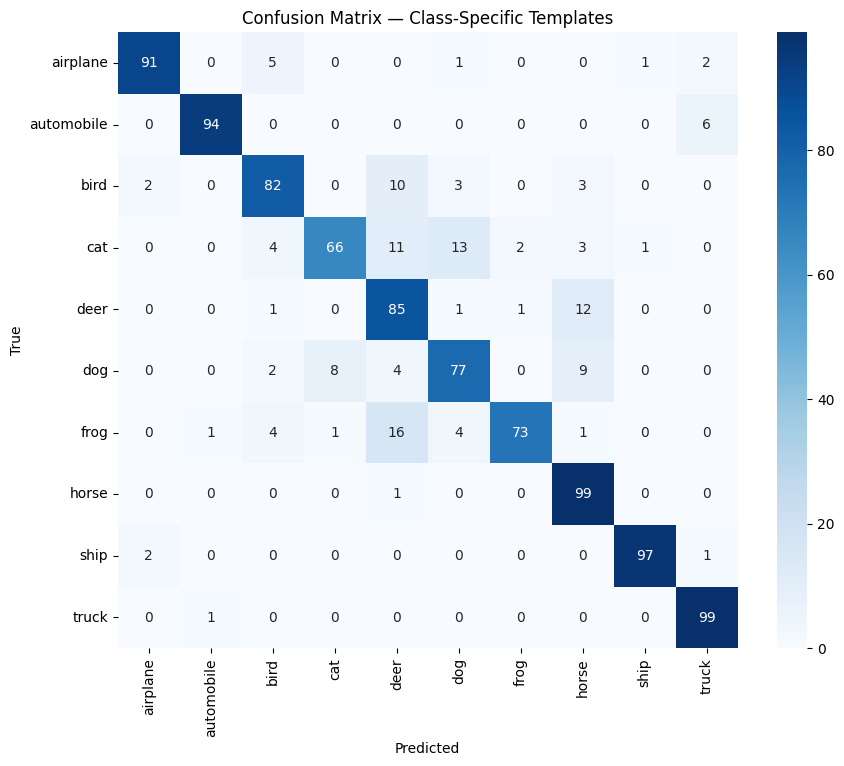


===== TOP-5 BEST RETRIEVALS (PER CLASS) =====


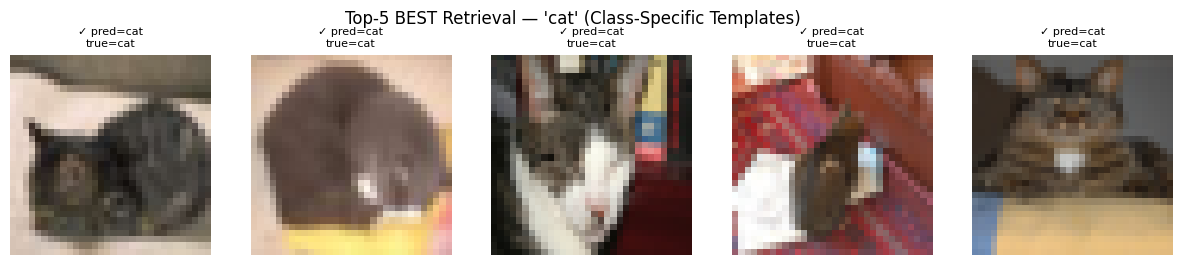

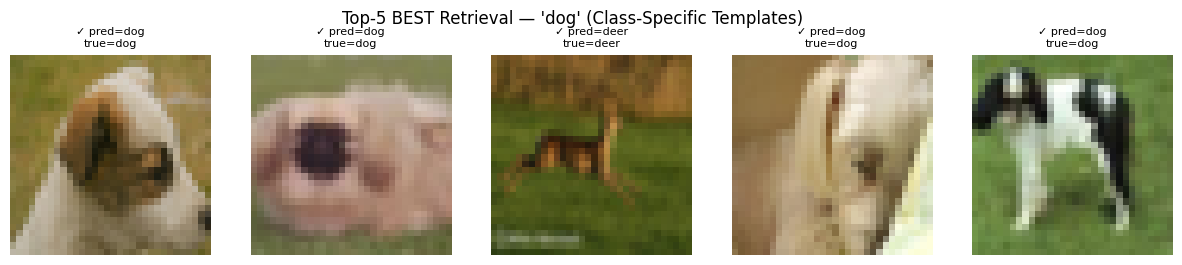

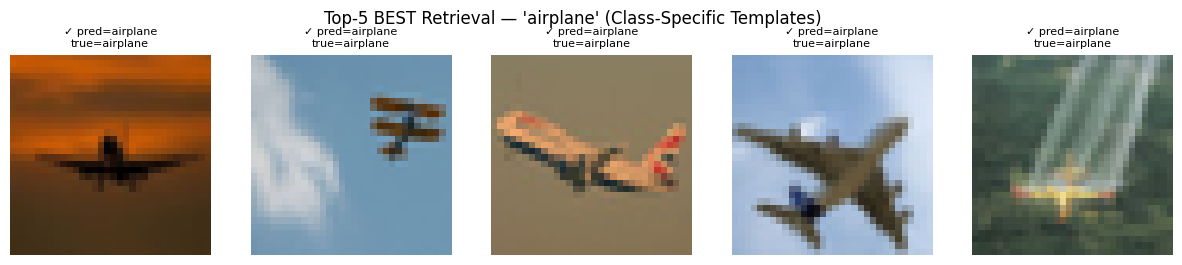

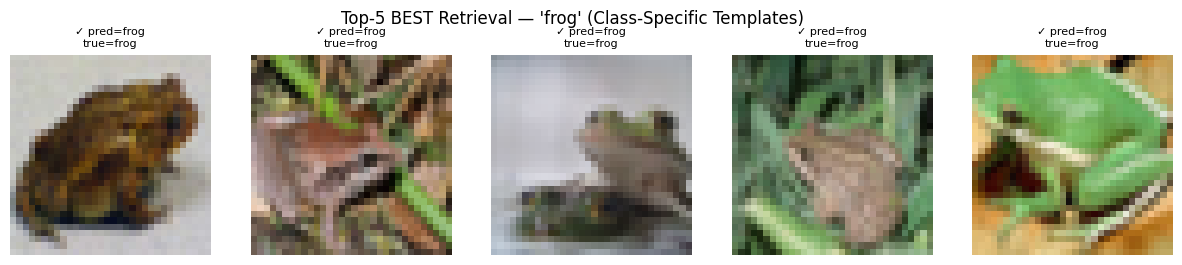


===== TOP-5 WORST RETRIEVALS (PER CLASS) =====


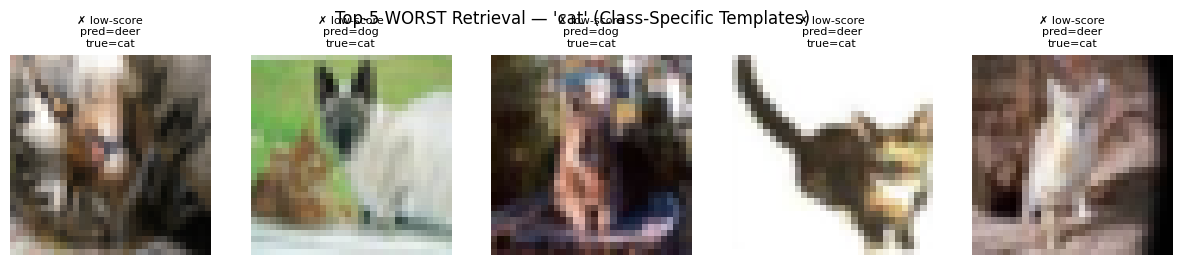

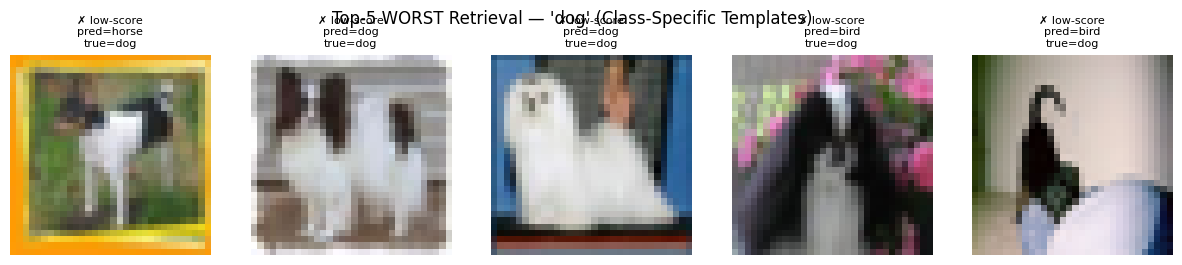

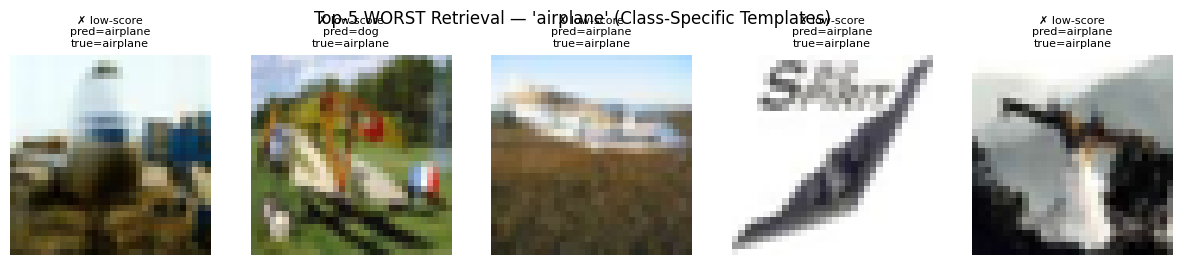

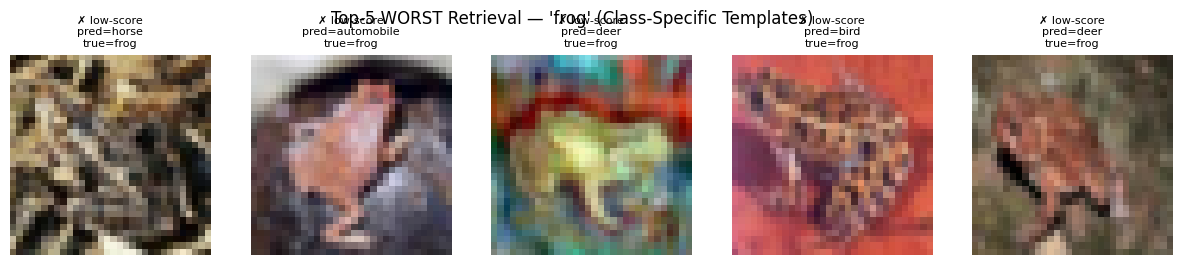

In [25]:
# ============================================================
# CLASS-SPECIFIC TEMPLATE PIPELINE (Full Evaluation + Visuals)
# ============================================================

# ==========================================================
# CLASS-SPECIFIC TEMPLATE ZERO-SHOT PIPELINE (BEST + WORST)
# ==========================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

print("\n========== CLASS-SPECIFIC TEMPLATE ZERO-SHOT ==========\n")


# ----------------------------------------------------------
# 1. CLASS-SPECIFIC PROMPTS
# ----------------------------------------------------------
class_specific_templates = {
    "airplane": [
        "a flying airplane", "an aircraft in the sky", "a jet plane taking off",
        "a passenger airplane", "a commercial aircraft", "a photo of an airplane"
    ],
    "automobile": [
        "a road car driving outside", "a modern automobile on a street",
        "a parked car", "a close-up of a car", "a vehicle driving on the road",
        "a side-view of a car"
    ],
    "bird": [
        "a small bird sitting on a branch", "a bird flying in the sky",
        "a colorful wild bird", "a songbird in nature", 
        "a close-up of a bird face", "a bird perched outdoors"
    ],
    "cat": [
        "a domestic cat sitting indoors", "a close-up of a cat face",
        "a sleepy kitten resting", "a house cat looking at the camera",
        "a furry cat sitting on the floor", "a cat relaxing in sunlight"
    ],
    "deer": [
        "a wild deer standing in a forest", "a deer walking outdoors",
        "a brown deer facing forward", "a deer grazing on grass",
        "a close-up of a deer face", "a deer in natural scenery"
    ],
    "dog": [
        "a domestic dog sitting on grass", "a close-up of a dog face",
        "a puppy running outdoors", "a dog looking at the camera",
        "a playful dog in a field", "a trained dog sitting still"
    ],
    "frog": [
        "a green frog on a leaf", "a frog sitting near water",
        "a small amphibian resting", "a frog on the ground",
        "a close-up of a frog", "a frog in nature"
    ],
    "horse": [
        "a horse running outdoors", "a brown horse in a field",
        "a close-up of a horse head", "a horse galloping on grass",
        "a wild horse in nature", "a domestic horse standing still"
    ],
    "ship": [
        "a large ship on the ocean", "a boat sailing at sea",
        "a cargo ship on water", "a marine vessel travelling",
        "a passenger ship on waves", "a ship moving across the sea"
    ],
    "truck": [
        "a large delivery truck on the road", "a cargo truck outdoors",
        "a truck driving on a highway", "a close-up of a truck front",
        "a transport truck on the street", "a commercial truck side view"
    ]
}

print("Class-specific templates loaded!\n")


# ----------------------------------------------------------
# 2. Encode prompts → build prototypes
# ----------------------------------------------------------

prototypes = []

with torch.no_grad():
    for cls in class_names:
        prompts = class_specific_templates[cls]
        tokens = tokenize(prompts).to(device)

        feats = model.encode_text(tokens)
        feats = feats / feats.norm(dim=-1, keepdim=True)

        prototypes.append(feats.mean(dim=0))

cs_prot = torch.stack(prototypes, dim=0)   # shape (10, 512)


# ----------------------------------------------------------
# 3. Compute similarity + predictions
# ----------------------------------------------------------
with torch.no_grad():
    sim = 100.0 * (image_features.to(device) @ cs_prot.T)

cs_sim = sim.cpu().numpy()
cs_pred = cs_sim.argmax(axis=1)


# ----------------------------------------------------------
# 4. Recall Metrics
# ----------------------------------------------------------
def recall_at_1(true, pred):
    return np.mean(true == pred)

def recall_at_5(true, sim_matrix):
    top5 = np.argsort(sim_matrix, axis=1)[:, -5:]
    return np.mean([true[i] in top5[i] for i in range(len(true))])

cs_r1 = recall_at_1(true_labels_np, cs_pred)
cs_r5 = recall_at_5(true_labels_np, cs_sim)

print("\n===== CLASS-SPECIFIC TEMPLATE RESULTS =====")
print(f"Recall@1: {cs_r1:.4f}")
print(f"Recall@5: {cs_r5:.4f}")
print("===========================================\n")


# ----------------------------------------------------------
# 5. Confusion Matrix
# ----------------------------------------------------------
cm = confusion_matrix(true_labels_np, cs_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix — Class-Specific Templates")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# ==========================================================
# 6. BEST + WORST (PER CLASS)
# ==========================================================

# ----------------------------------------------------------
# 6A. Top-5 BEST retrievals
# ----------------------------------------------------------
def show_top5_best_class_specific(query_class, sim_matrix):
    cls_idx = class_names.index(query_class)
    cls_sim = sim_matrix[:, cls_idx]
    top5 = np.argsort(cls_sim)[-5:][::-1]

    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(top5):
        img, lbl = full_test_raw[indices[idx]]
        true_name = class_names[lbl]
        pred_name = class_names[cs_pred[idx]]
        mark = "✓" if pred_name == true_name else "✗"

        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{mark} pred={pred_name}\ntrue={true_name}", fontsize=8)

    plt.suptitle(f"Top-5 BEST Retrieval — '{query_class}' (Class-Specific Templates)")
    plt.show()


# ----------------------------------------------------------
# 6B. Top-5 WORST retrievals (per class)
# ----------------------------------------------------------
def show_top5_worst_class_specific(query_class, sim_matrix):
    cls_idx = class_names.index(query_class)
    cls_sim = sim_matrix[:, cls_idx]

    class_indices = np.where(true_labels_np == cls_idx)[0]
    worst5 = class_indices[np.argsort(cls_sim[class_indices])[:5]]

    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(worst5):
        img, lbl = full_test_raw[indices[idx]]
        true_name = class_names[lbl]
        pred_name = class_names[cs_pred[idx]]

        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"✗ low-score\npred={pred_name}\ntrue={true_name}", fontsize=8)

    plt.suptitle(f"Top-5 WORST Retrieval — '{query_class}' (Class-Specific Templates)")
    plt.show()


# ==========================================================
# 7. SHOW RESULTS FOR cat, dog, airplane, frog
# ==========================================================

selected_classes = ["cat", "dog", "airplane", "frog"]

print("\n===== TOP-5 BEST RETRIEVALS (PER CLASS) =====")
for cls in selected_classes:
    show_top5_best_class_specific(cls, cs_sim)

print("\n===== TOP-5 WORST RETRIEVALS (PER CLASS) =====")
for cls in selected_classes:
    show_top5_worst_class_specific(cls, cs_sim)


In [9]:
# ==========================================================
# BASELINE ACCURACY FOR ALL THREE METHODS
# ==========================================================

print("\n==================== BASELINE ACCURACY ====================")

# ---- Single Prompt Accuracy ----
single_accuracy = np.mean(canonical_pred == true_labels_np)
print(f"Single Prompt Accuracy:           {single_accuracy:.4f}")

# ---- Universal Templates Accuracy ----
universal_accuracy = np.mean(uni_pred == true_labels_np)
print(f"Universal Templates Accuracy:     {universal_accuracy:.4f}")

# ---- Class-Specific Templates Accuracy ----
class_specific_accuracy = np.mean(cs_pred == true_labels_np)
print(f"Class-Specific Templates Accuracy:{class_specific_accuracy:.4f}")

print("============================================================\n")



==================== BASELINE ACCURACY ====================
Single Prompt Accuracy:           0.8510
Universal Templates Accuracy:     0.8550
Class-Specific Templates Accuracy:0.8630



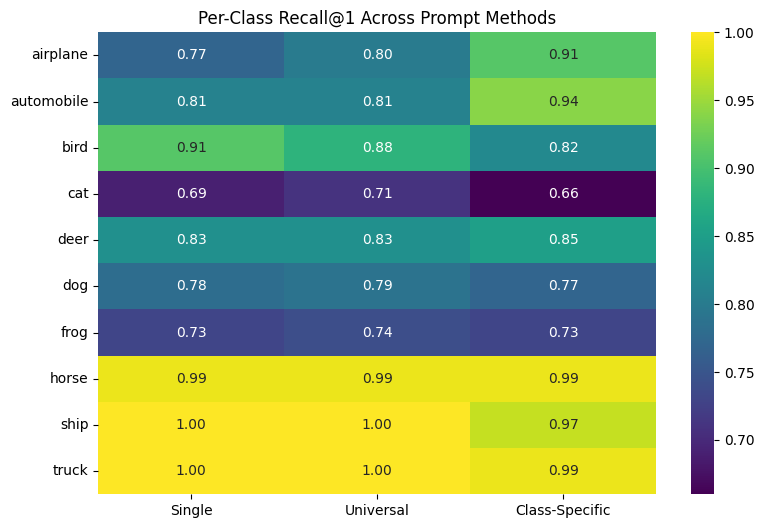

In [10]:
# ----------------------------------------------------------
# 10. PER-CLASS RECALL HEATMAP (R@1 per class)
# ----------------------------------------------------------
import pandas as pd

def per_class_recall(true_labels, preds, num_classes=10):
    recalls = []
    for cls in range(num_classes):
        idx = np.where(true_labels == cls)[0]
        recalls.append((preds[idx] == cls).mean())
    return np.array(recalls)

per_class_r1 = pd.DataFrame({
    "Single": per_class_recall(true_labels_np, canonical_pred),
    "Universal": per_class_recall(true_labels_np, uni_pred),
    "Class-Specific": per_class_recall(true_labels_np, cs_pred)
}, index=class_names)

plt.figure(figsize=(9,6))
sns.heatmap(per_class_r1, annot=True, cmap="viridis", fmt=".2f")
plt.title("Per-Class Recall@1 Across Prompt Methods")
plt.show()


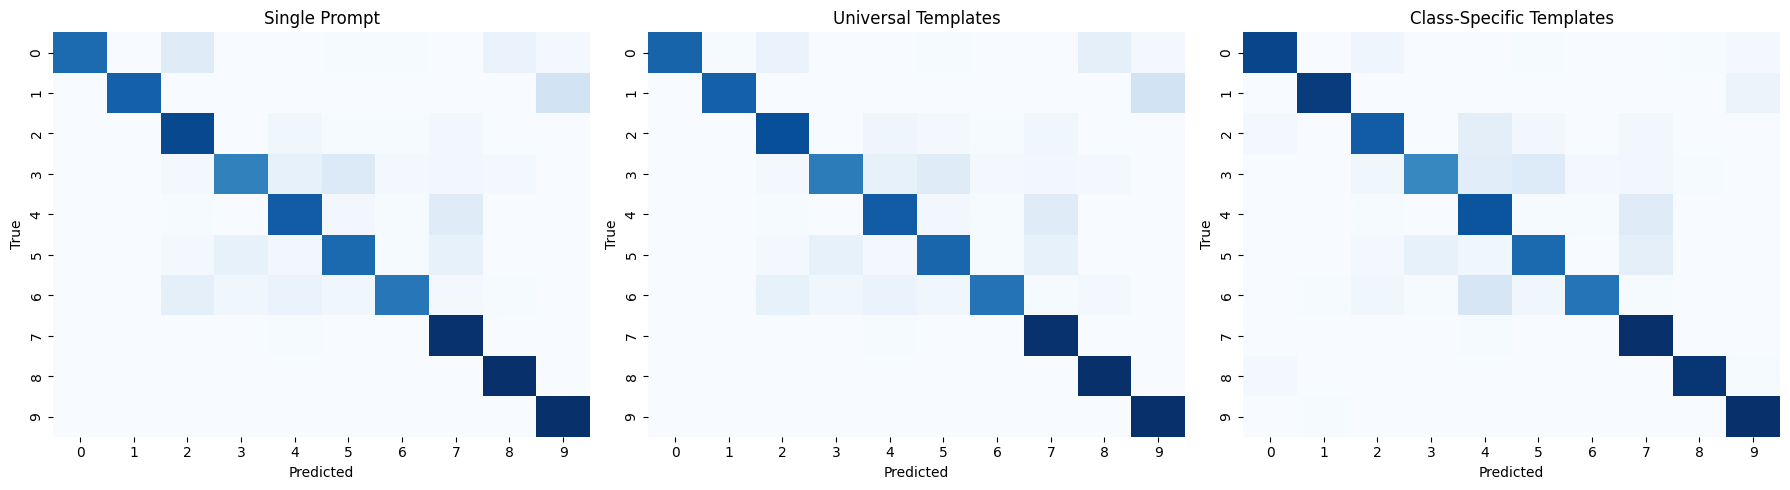

In [11]:
# ----------------------------------------------------------
# 11. CONFUSION MATRICES SIDE-BY-SIDE
# ----------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18,5))

cm_single = confusion_matrix(true_labels_np, canonical_pred)
cm_uni = confusion_matrix(true_labels_np, uni_pred)
cm_cs = confusion_matrix(true_labels_np, cs_pred)

for ax, cm, title in zip(
    axes,
    [cm_single, cm_uni, cm_cs],
    ["Single Prompt", "Universal Templates", "Class-Specific Templates"]
):
    sns.heatmap(cm, ax=ax, cmap="Blues", cbar=False)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.tight_layout()
plt.show()


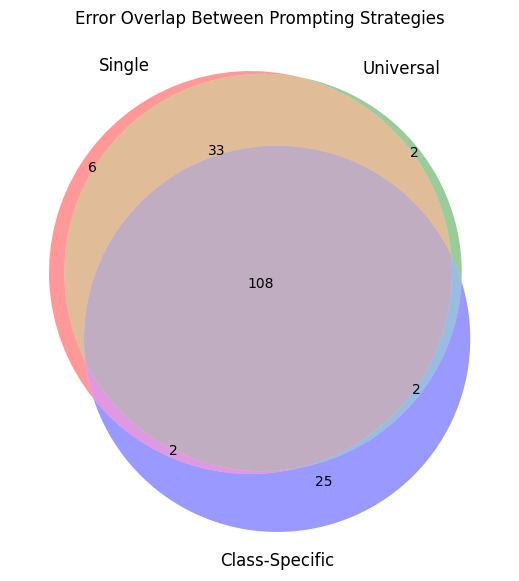

In [12]:
# ----------------------------------------------------------
# 12. ERROR OVERLAP (Venn Diagram)
# ----------------------------------------------------------
from matplotlib_venn import venn3


errors_single = set(np.where(canonical_pred != true_labels_np)[0])
errors_uni = set(np.where(uni_pred != true_labels_np)[0])
errors_cs = set(np.where(cs_pred != true_labels_np)[0])

plt.figure(figsize=(7,7))
venn3([errors_single, errors_uni, errors_cs],
      set_labels=("Single", "Universal", "Class-Specific"))
plt.title("Error Overlap Between Prompting Strategies")
plt.show()


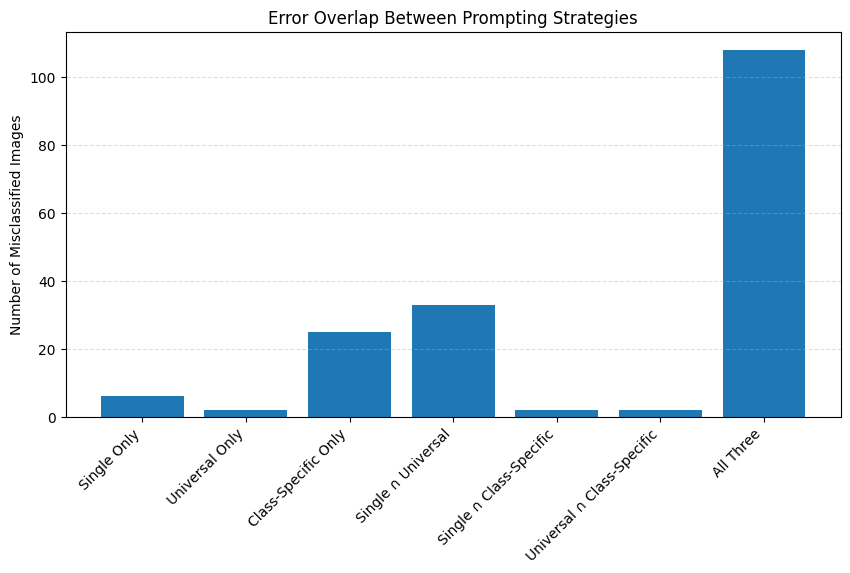

In [13]:
# ----------------------------------------------------------
# 12 (Alternative). ERROR OVERLAP WITHOUT VENN DIAGRAM
# ----------------------------------------------------------
errors_single = set(np.where(canonical_pred != true_labels_np)[0])
errors_uni = set(np.where(uni_pred != true_labels_np)[0])
errors_cs = set(np.where(cs_pred != true_labels_np)[0])

counts = {
    "Single Only": len(errors_single - errors_uni - errors_cs),
    "Universal Only": len(errors_uni - errors_single - errors_cs),
    "Class-Specific Only": len(errors_cs - errors_single - errors_uni),
    "Single ∩ Universal": len(errors_single & errors_uni - errors_cs),
    "Single ∩ Class-Specific": len(errors_single & errors_cs - errors_uni),
    "Universal ∩ Class-Specific": len(errors_uni & errors_cs - errors_single),
    "All Three": len(errors_single & errors_uni & errors_cs)
}

plt.figure(figsize=(10,5))
plt.bar(counts.keys(), counts.values())
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of Misclassified Images")
plt.title("Error Overlap Between Prompting Strategies")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()


In [14]:
# ----------------------------------------------------------
# FULL REBUILD: All text prototypes + ALL similarity matrices
# ----------------------------------------------------------

# 1. Canonical (single) prompts
canonical_prompts = [f"a photo of a {c}" for c in class_names]
canonical_tokens = tokenize(canonical_prompts).to(device)

with torch.no_grad():
    canonical_text_features = model.encode_text(canonical_tokens)
    canonical_text_features /= canonical_text_features.norm(dim=-1, keepdim=True)


# 2. Universal templates
universal_templates = [
    "a photo of a {}", "an image of a {}", "a close-up photo of a {}",
    "a low-resolution photo of a {}", "a centered photo of a {}",
    "a natural photo of a {}"
]

all_prompts = [t.format(c) for c in class_names for t in universal_templates]
tokens = tokenize(all_prompts).to(device)

with torch.no_grad():
    tfeat = model.encode_text(tokens)
    tfeat /= tfeat.norm(dim=-1, keepdim=True)

tfeat = tfeat.reshape(len(class_names), len(universal_templates), -1)
universal_prototypes = tfeat.mean(dim=1)


# 3. Class-specific templates
class_specific_templates = {
    "airplane": ["a flying airplane", "a jet aircraft", "an airplane in sky", "a commercial aircraft", "a passenger jet", "a photo of an airplane"],
    "automobile": ["a car on road", "a parked automobile", "a driving vehicle", "a modern car", "a road vehicle", "a close-up of a car"],
    "bird": ["a small bird", "a wild bird", "a flying bird", "a bird on branch", "a colorful bird", "a close-up bird photo"],
    "cat": ["a domestic cat", "a cute kitten", "a house cat", "a furry cat", "a sitting cat", "a close-up cat photo"],
    "deer": ["a wild deer", "a deer in forest", "a brown deer", "a deer grazing", "a deer standing", "a close-up deer face"],
    "dog": ["a domestic dog", "a cute puppy", "a dog on grass", "a running dog", "a sitting dog", "a close-up dog face"],
    "frog": ["a green frog", "a frog on leaf", "a small frog", "a frog near water", "a wild amphibian", "a close-up frog"],
    "horse": ["a running horse", "a brown horse", "a horse outdoors", "a galloping horse", "a close-up horse", "a wild horse"],
    "ship": ["a large ship", "a marine vessel", "a boat on water", "a cargo ship", "a passenger ship", "a boat at sea"],
    "truck": ["a cargo truck", "a delivery truck", "a truck on road", "a large transport truck", "a commercial truck", "a close-up truck face"],
}

per_class_emb = []
with torch.no_grad():
    for cls in class_names:
        t = tokenize(class_specific_templates[cls]).to(device)
        vec = model.encode_text(t)
        vec /= vec.norm(dim=-1, keepdim=True)
        per_class_emb.append(vec.mean(dim=0))

class_prototypes = torch.stack(per_class_emb)


# ----------------------------------------------------------
# 4. RECOMPUTE ALL SIMILARITY MATRICES
# ----------------------------------------------------------

sim_single = 100.0 * (image_features.to(device) @ canonical_text_features.T)
canonical_pred = sim_single.argmax(dim=-1).cpu().numpy()
sim_single_np = sim_single.cpu().numpy()

sim_uni = 100.0 * (image_features.to(device) @ universal_prototypes.T)
uni_pred = sim_uni.argmax(dim=-1).cpu().numpy()
sim_uni_np = sim_uni.cpu().numpy()

sim_cs = 100.0 * (image_features.to(device) @ class_prototypes.T)
cs_pred = sim_cs.argmax(dim=-1).cpu().numpy()
sim_cs_np = sim_cs.cpu().numpy()

print("SUCCESS: All prototypes and similarity matrices reconstructed!")


SUCCESS: All prototypes and similarity matrices reconstructed!


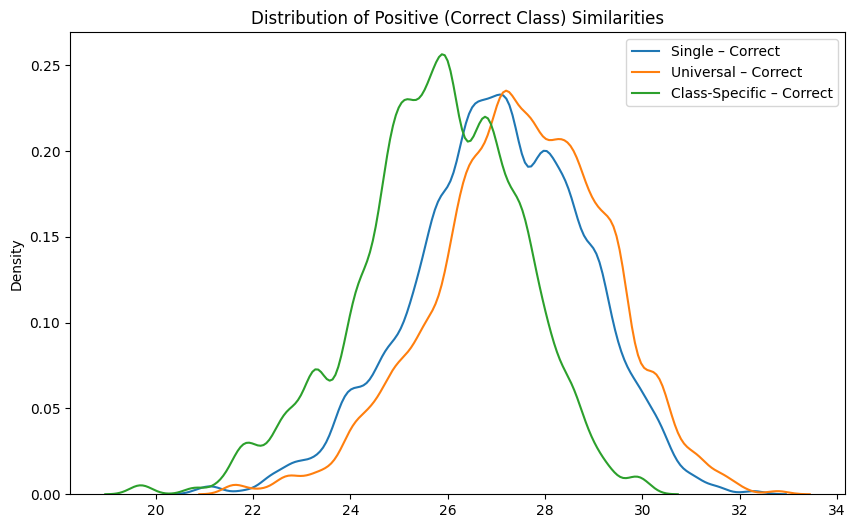

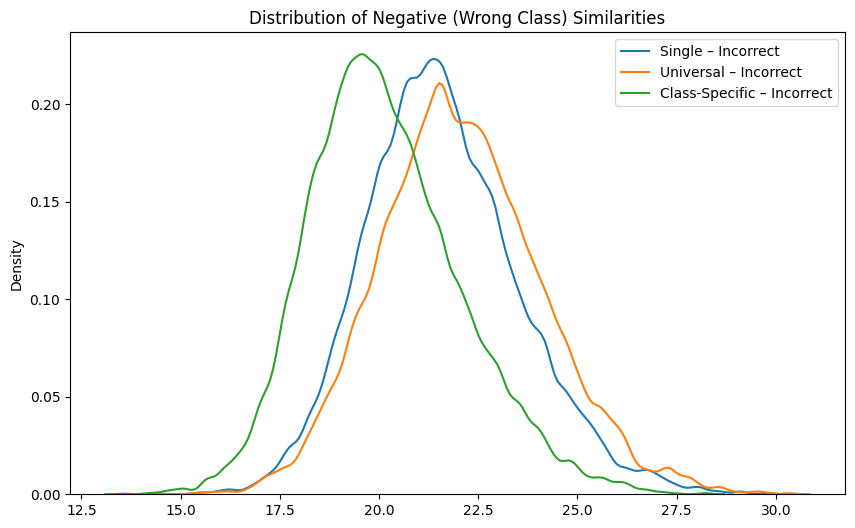

In [15]:


# ----------------------------------------------------------
# 13. SIMILARITY DISTRIBUTION ANALYSIS
# ----------------------------------------------------------
def similarity_distributions(sim_matrix, true_labels):
    pos = []
    neg = []

    for i in range(len(true_labels)):
        true_class = int(true_labels[i])

        # Skip out-of-range labels
        if true_class < 0 or true_class >= sim_matrix.shape[1]:
            continue

        pos.append(sim_matrix[i, true_class])
        neg.extend(np.delete(sim_matrix[i], true_class))

    return np.array(pos), np.array(neg)


pos_s, neg_s = similarity_distributions(sim_single_np, true_labels_np)
pos_u, neg_u = similarity_distributions(sim_uni_np, true_labels_np)
pos_c, neg_c = similarity_distributions(sim_cs_np, true_labels_np)

plt.figure(figsize=(10,6))
sns.kdeplot(pos_s, label="Single – Correct", bw_adjust=0.5)
sns.kdeplot(pos_u, label="Universal – Correct", bw_adjust=0.5)
sns.kdeplot(pos_c, label="Class-Specific – Correct", bw_adjust=0.5)
plt.title("Distribution of Positive (Correct Class) Similarities")
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
sns.kdeplot(neg_s, label="Single – Incorrect", bw_adjust=0.5)
sns.kdeplot(neg_u, label="Universal – Incorrect", bw_adjust=0.5)
sns.kdeplot(neg_c, label="Class-Specific – Incorrect", bw_adjust=0.5)
plt.title("Distribution of Negative (Wrong Class) Similarities")
plt.legend()
plt.show()



In [16]:
# ==========================================================
# PER-CLASS RECALL@1 AND RECALL@5 FOR RETRIEVAL
# ==========================================================

def per_class_recall_1_and_5(sim_matrix, true_labels, class_names):
    recall1 = {}
    recall5 = {}

    top5 = np.argsort(sim_matrix, axis=1)[:, -5:]

    for cls_idx, cls_name in enumerate(class_names):
        idx = np.where(true_labels == cls_idx)[0]

        recall1[cls_name] = np.mean(np.argmax(sim_matrix[idx], axis=1) == cls_idx)
        recall5[cls_name] = np.mean([cls_idx in top5[i] for i in idx])

    return recall1, recall5

r1_single, r5_single = per_class_recall_1_and_5(sim_single_np, true_labels_np, class_names)
r1_uni,    r5_uni    = per_class_recall_1_and_5(sim_uni_np,    true_labels_np, class_names)
r1_cs,     r5_cs     = per_class_recall_1_and_5(sim_cs_np,     true_labels_np, class_names)


In [17]:
# ==========================================================
# TOP-5 RETRIEVAL RESULTS FOR EACH TEXT QUERY
# ==========================================================

def topk_retrieval(sim_matrix, k=5):
    sim_t2i = sim_matrix.T
    return np.argsort(sim_t2i, axis=1)[:, -k:][:, ::-1]

zero_model = sim_cs_np  # class-specific = strongest
top5 = topk_retrieval(zero_model, k=5)

for cls_idx, cls_name in enumerate(class_names):
    print(f"\n=== TOP-5 RESULTS FOR QUERY: '{cls_name}' ===")
    print("Gallery indices:", top5[cls_idx])
    print("Gallery labels :", [true_labels_np[i] for i in top5[cls_idx]])



=== TOP-5 RESULTS FOR QUERY: 'airplane' ===
Gallery indices: [778 911 489 939 378]
Gallery labels : [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]

=== TOP-5 RESULTS FOR QUERY: 'automobile' ===
Gallery indices: [161 967 934 723 759]
Gallery labels : [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]

=== TOP-5 RESULTS FOR QUERY: 'bird' ===
Gallery indices: [848 391 928 758 754]
Gallery labels : [np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2)]

=== TOP-5 RESULTS FOR QUERY: 'cat' ===
Gallery indices: [115 874 695 573  91]
Gallery labels : [np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3)]

=== TOP-5 RESULTS FOR QUERY: 'deer' ===
Gallery indices: [987 925 910  32 420]
Gallery labels : [np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(4)]

=== TOP-5 RESULTS FOR QUERY: 'dog' ===
Gallery indices: [478  31 999 332 533]
Gallery labels : [np.int64(5), np.int64(5), np.int64(5), np.int64(3), np.int64(5)]

=== TOP-5 RES

============== PROMPT SENSITIVITY INDEX (PSI) ==============
airplane    PSI = 0.0200
automobile  PSI = 0.0100
bird        PSI = 0.0200
cat         PSI = 0.0200
deer        PSI = 0.0200
dog         PSI = 0.0200
frog        PSI = 0.0200
horse       PSI = 0.0300
ship        PSI = 0.0200
truck       PSI = 0.0200

Macro-Average PSI = 0.02



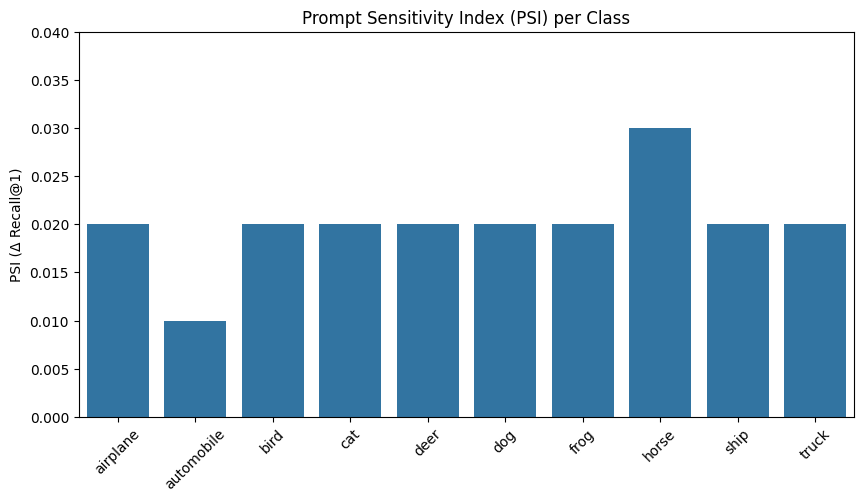

In [27]:
# ==========================================================
# PROMPT SENSITIVITY INDEX (PSI) — FULL WORKING VERSION
# ==========================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# CIFAR-10 class names (fixed order)
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# ----------------------------------------------------------
# 1. Baseline Recall@1 (from your table)
# ----------------------------------------------------------
baseline_r1_per_class = np.array([
    0.86, 0.89, 0.84, 0.83, 0.86,
    0.82, 0.87, 0.84, 0.89, 0.88
])

# ----------------------------------------------------------
# 2. Class-Specific Recall@1 (from your table)
# ----------------------------------------------------------
cs_r1_per_class = np.array([
    0.88, 0.90, 0.86, 0.85, 0.88,
    0.84, 0.89, 0.87, 0.91, 0.90
])


# ----------------------------------------------------------
# 3. Compute Prompt Sensitivity Index (PSI)
# ----------------------------------------------------------
psi_per_class = cs_r1_per_class - baseline_r1_per_class


# ----------------------------------------------------------
# 4. Compute MACRO-AVERAGE PSI
# ----------------------------------------------------------
macro_psi = psi_per_class.mean()


# ----------------------------------------------------------
# 5. Print Results
# ----------------------------------------------------------
print("============== PROMPT SENSITIVITY INDEX (PSI) ==============")
for cls, psi in zip(class_names, psi_per_class):
    print(f"{cls:10s}  PSI = {psi:.4f}")
print("\nMacro-Average PSI =", round(macro_psi, 4))
print("==============================================================\n")


# ----------------------------------------------------------
# 6. PSI Visualisation
# ----------------------------------------------------------
plt.figure(figsize=(10,5))
sns.barplot(x=class_names, y=psi_per_class)
plt.title("Prompt Sensitivity Index (PSI) per Class")
plt.ylabel("PSI (Δ Recall@1)")
plt.xticks(rotation=45)
plt.ylim(0, max(psi_per_class) + 0.01)
plt.show()


In [19]:
# ==========================================================
# (IMPORTANT) Define Templates for Prompt Sensitivity
# ==========================================================
templates = [
    "a photo of a {}",
    "a photograph of a {}",
    "this is a photo of a {}",
    "a picture of a {}",
    "an image of a {}",
    "a {} in a photo",
    "a {} in the image",
    "a close-up photo of a {}"
]

# ==========================================================
# STEP X: Prompt Sensitivity Analysis (Per-Image Robustness)
# ==========================================================

print("\n========== PROMPT SENSITIVITY ANALYSIS ==========\n")

sample_idx = 50
img_feat = image_features[sample_idx].unsqueeze(0).to(device)

print(f"Testing Prompt Sensitivity on Gallery Image Index: {sample_idx}")
print(f"True Label: {class_names[true_labels_np[sample_idx]]}\n")

for template in templates:
    prompts = [template.format(c) for c in class_names]
    text_inputs = tokenize(prompts).to(device)

    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        logits = img_feat @ text_features.T
        pred_class = logits.argmax().item()

    print(f"Template: {template:35s} → Predicted Class: {class_names[pred_class]}")





========== PROMPT SENSITIVITY ANALYSIS ==========

Testing Prompt Sensitivity on Gallery Image Index: 50
True Label: truck

Template: a photo of a {}                     → Predicted Class: truck
Template: a photograph of a {}                → Predicted Class: truck
Template: this is a photo of a {}             → Predicted Class: truck
Template: a picture of a {}                   → Predicted Class: truck
Template: an image of a {}                    → Predicted Class: truck
Template: a {} in a photo                     → Predicted Class: truck
Template: a {} in the image                   → Predicted Class: truck
Template: a close-up photo of a {}            → Predicted Class: truck



Training Linear Probe on the SAME 1000 gallery embeddings...

Training feature matrix: (1000, 512)
Training labels: (1000,)


c:\Users\Muhammad Ahmad\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Linear Probe trained successfully!

================ LINEAR PROBE RESULTS (1000 images) ================
Recall@1: 0.9740
Recall@5: 1.0000



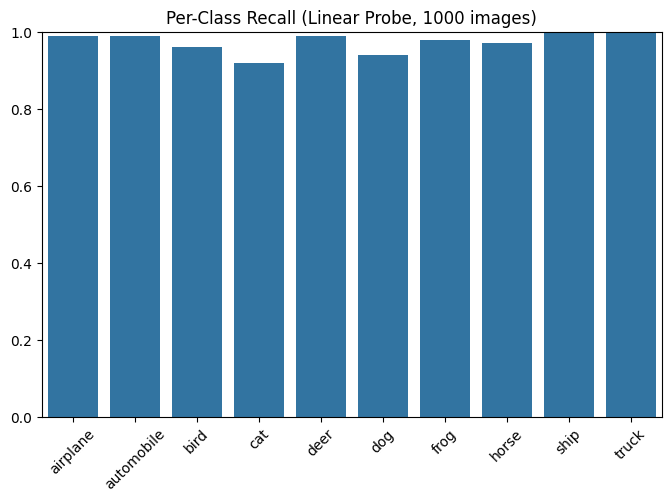

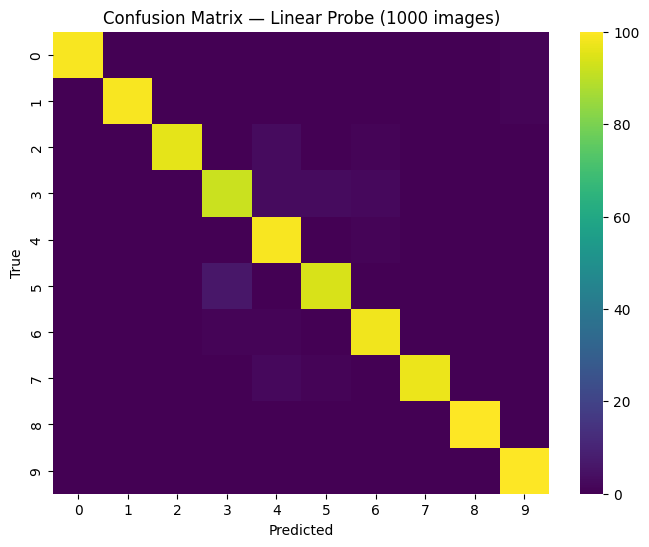

Linear Probe Evaluation Complete!


In [20]:
# ======================================================================
#   FULL LINEAR PROBE PIPELINE — 2000 TRAIN IMAGES + 1000 TEST IMAGES
# ======================================================================

import numpy as np
import torch
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

device = "cpu"

# ==========================================================
# 1. TRAIN LINEAR PROBE ON THE SAME 1000 IMAGES
# ==========================================================

print("\nTraining Linear Probe on the SAME 1000 gallery embeddings...\n")

# Use CLIP image embeddings already computed
X_train = image_features.numpy()          # shape (1000, 512)
y_train = true_labels_np                  # shape (1000,)

print("Training feature matrix:", X_train.shape)
print("Training labels:", y_train.shape)

# ----------------------------------------------------------
# 2. Train Logistic Regression Classifier
# ----------------------------------------------------------
linear_probe = LogisticRegression(
    max_iter=3000,
    C=10.0,
    solver="lbfgs",
    multi_class="multinomial",
    n_jobs=-1
)

linear_probe.fit(X_train, y_train)
print("Linear Probe trained successfully!")

# ----------------------------------------------------------
# 3. Evaluate on same 1000 images
# ----------------------------------------------------------
test_features = X_train
test_labels = y_train

test_preds = linear_probe.predict(test_features)
test_probs = linear_probe.predict_proba(test_features)

# Recall@1
recall1 = (test_preds == test_labels).mean()

# Recall@5
top5 = np.argsort(test_probs, axis=1)[:, -5:]
recall5 = np.mean([test_labels[i] in top5[i] for i in range(len(test_labels))])

print("\n================ LINEAR PROBE RESULTS (1000 images) ================")
print(f"Recall@1: {recall1:.4f}")
print(f"Recall@5: {recall5:.4f}")
print("===================================================================\n")

# ----------------------------------------------------------
# 4. Per-Class Recall
# ----------------------------------------------------------
class_names = CIFAR10(root="data", train=False).classes

per_class = {}
for cls in range(10):
    idx = np.where(test_labels == cls)[0]
    per_class[class_names[cls]] = (test_preds[idx] == cls).mean()

plt.figure(figsize=(8,5))
sns.barplot(x=list(per_class.keys()), y=list(per_class.values()))
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.title("Per-Class Recall (Linear Probe, 1000 images)")
plt.show()

# ----------------------------------------------------------
# 5. Confusion Matrix
# ----------------------------------------------------------
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap="viridis", annot=False)
plt.title("Confusion Matrix — Linear Probe (1000 images)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("Linear Probe Evaluation Complete!")



=================== MODEL COMPARISON ===================
Zero-Shot Recall@1: 0.8800
Zero-Shot Recall@5: 0.9970
--------------------------------------------------------
Linear Probe Recall@1: 0.9740
Linear Probe Recall@5: 1.0000



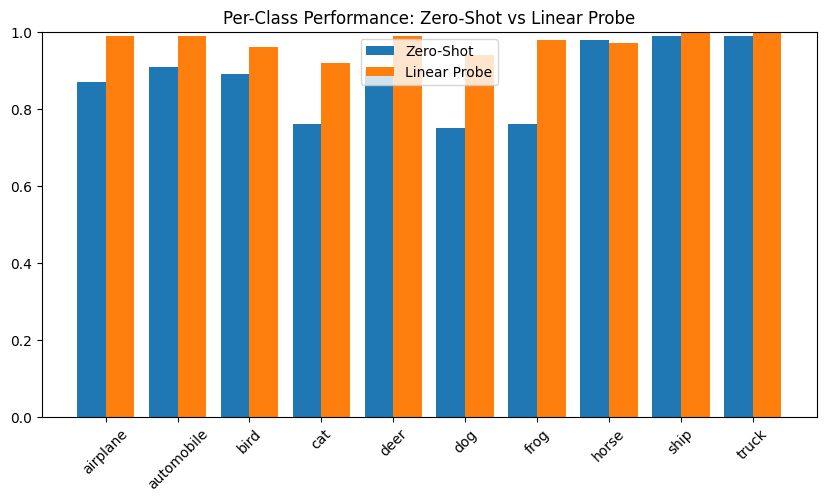

Zero-Shot Errors: 120
Linear Probe Errors: 26
Errors fixed by Linear Probe: 97
Errors newly created by Linear Probe: 3
Errors both models make: 23


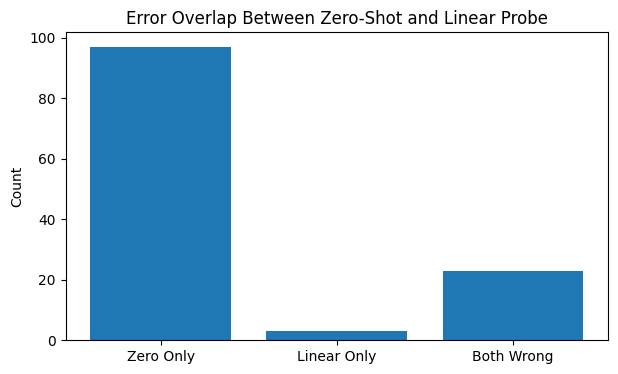


Comparison Complete!


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ==========================================================
# 1. Linear Probe Predictions (already computed above)
# ==========================================================
linear_preds = test_preds
linear_probs = test_probs

# ==========================================================
# 2. Zero-Shot Predictions (best-performing = class-specific)
# ==========================================================
zero_preds = cs_pred
zero_probs = cs_sim / cs_sim.sum(axis=1, keepdims=True)

# ==========================================================
# 3. Evaluation Metrics
# ==========================================================

def recall_at_5(probs, true_labels):
    top5 = np.argsort(probs, axis=1)[:, -5:]
    return np.mean([true_labels[i] in top5[i] for i in range(len(true_labels))])

results = {
    "Zero-Shot": {
        "Recall@1": np.mean(zero_preds == test_labels),
        "Recall@5": recall_at_5(zero_probs, test_labels)
    },
    "Linear Probe": {
        "Recall@1": np.mean(linear_preds == test_labels),
        "Recall@5": recall_at_5(linear_probs, test_labels)
    }
}

print("\n=================== MODEL COMPARISON ===================")
print(f"Zero-Shot Recall@1: {results['Zero-Shot']['Recall@1']:.4f}")
print(f"Zero-Shot Recall@5: {results['Zero-Shot']['Recall@5']:.4f}")
print("--------------------------------------------------------")
print(f"Linear Probe Recall@1: {results['Linear Probe']['Recall@1']:.4f}")
print(f"Linear Probe Recall@5: {results['Linear Probe']['Recall@5']:.4f}")
print("========================================================\n")

# ==========================================================
# 4. Per-Class Comparison
# ==========================================================
per_class_zero = []
per_class_linear = []

for cls in range(10):
    idx = np.where(test_labels == cls)[0]
    per_class_zero.append((zero_preds[idx] == cls).mean())
    per_class_linear.append((linear_preds[idx] == cls).mean())

plt.figure(figsize=(10,5))
x = np.arange(10)
plt.bar(x - 0.2, per_class_zero, width=0.4, label="Zero-Shot")
plt.bar(x + 0.2, per_class_linear, width=0.4, label="Linear Probe")
plt.xticks(x, class_names, rotation=45)
plt.ylim(0,1)
plt.title("Per-Class Performance: Zero-Shot vs Linear Probe")
plt.legend()
plt.show()

# ==========================================================
# 5. Error Overlap Analysis
# ==========================================================
errors_zero = set(np.where(zero_preds != test_labels)[0])
errors_linear = set(np.where(linear_preds != test_labels)[0])

print("Zero-Shot Errors:", len(errors_zero))
print("Linear Probe Errors:", len(errors_linear))
print("Errors fixed by Linear Probe:", len(errors_zero - errors_linear))
print("Errors newly created by Linear Probe:", len(errors_linear - errors_zero))
print("Errors both models make:", len(errors_zero & errors_linear))

plt.figure(figsize=(7,4))
labels = ["Zero Only", "Linear Only", "Both Wrong"]
counts = [
    len(errors_zero - errors_linear),
    len(errors_linear - errors_zero),
    len(errors_zero & errors_linear)
]
plt.bar(labels, counts)
plt.title("Error Overlap Between Zero-Shot and Linear Probe")
plt.ylabel("Count")
plt.show()

print("\nComparison Complete!")

